# Notebook demo de sesion de registro en campo



In [1]:
import sounddevice as sd       
from irma.session import RecordingSession
from irma.io import play, play_rec
from irma.process import make_filterbank
from irma.room import paracoustic
from irma.display import *

# Ajuste de sounddevice
Elegir la interfaz de entrada salida si es necesario con sd.default_device[devicein,deviceout] usando los numeros que devuelve query_devices()

In [3]:
sd.query_devices()

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Microphone (Logitech BRIO), MME (2 in, 0 out)
   2 Microphone (Virtual Desktop Aud, MME (2 in, 0 out)
   3 Microphone (Realtek(R) Audio), MME (2 in, 0 out)
   4 Headset Microphone (Oculus Virt, MME (2 in, 0 out)
   5 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  6 Speakers (Realtek(R) Audio), MME (0 in, 2 out)
   7 Headphones (Oculus Virtual Audi, MME (0 in, 2 out)
   8 Nx Headphones (Waves Virtual Au, MME (0 in, 2 out)
   9 Realtek Digital Output (Realtek, MME (0 in, 2 out)
  10 Primary Sound Capture Driver, Windows DirectSound (2 in, 0 out)
  11 Microphone (Logitech BRIO), Windows DirectSound (2 in, 0 out)
  12 Microphone (Virtual Desktop Audio), Windows DirectSound (2 in, 0 out)
  13 Microphone (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  14 Headset Microphone (Oculus Virtual Audio Device), Windows DirectSound (2 in, 0 out)
  15 Primary Sound Driver, Windows DirectSound (0 in, 2 out)
  16 Speakers (Realte

In [8]:
#sd.default.device = [2,2]
fs = 48000

# Inicio de Sesion

Generacion de Metadata y nombres de archivo para los registros

In [9]:
parlantes = ["L","R","centro"]
mics = ["pub1","pub2"]
tipo = "Mono"
inchan = [1,2]
outchan = [1,2]
loopback = 1
s = RecordingSession("Session1",parlantes,mics,inchan=inchan,outchan=outchan,loopback=loopback,
                     rtype=tipo,sampling_rate=fs,sweepfile="../../sweep_x1_48k_10s_30_22k")

In [10]:
vars(s)

{'session_id': 'Session1',
 'speakers': ['L', 'R', 'centro'],
 'microphones': ['pub1', 'pub2'],
 'speaker_pos': [0, 0],
 'microphone_pos': [0, 0],
 'input_channels': [1, 2],
 'output_channels': [1, 2],
 'loopback': 1,
 'sampling_rate': 48000,
 'rtype': 'Mono',
 'date': '2023-05-29',
 'hour': '00:54:06',
 'comments': '',
 'saved': False,
 'sweep_file': '../../sweep_x1_48k_10s_30_22k',
 'recording_path': '',
 'recordings': []}

In [6]:
# Recovering an interrupted session
# s = RecordingSession.load_metadata("Sesion1")

# Grabacion de Respuesta Impulso

In [11]:
# los argumentos son: #parlante, #mic #dir #take #comentarios. 
parlante=2
mic=1
direction=1
take=1
comment = "un comentario"
ir1 = s.record_ir(parlante,mic,direction=direction,take=take,comment=comment)

Recording ... Session1_S2_M1_D1_1ch_loop_Mono
finished
Maximum sample value = 0.233642578125
Extracting ---> Session1_S2_M1_D1_1ch_loop_Mono
IR shape = (275456, 1)
DONE


([<AxesSubplot:title={'center':'IMPULSE RESPONSE'}, xlabel='Time (s)'>],
 <Figure size 1800x300 with 1 Axes>)

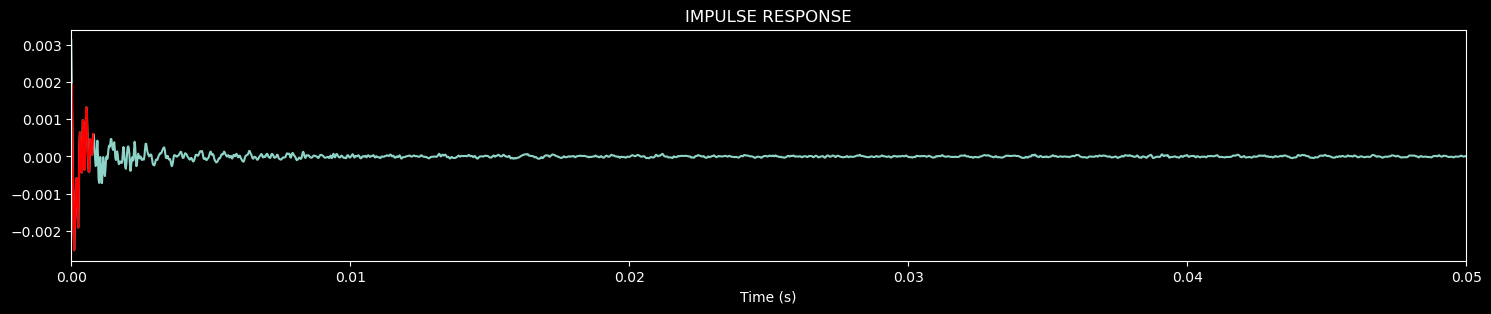

In [12]:
ir_plot(ir1,fs=fs,tmax=0.05)

## Acceder a registros previos

In [9]:
# lista de grabaciones (para agregar comentarios comments=True)
s.list_recordings(comments=True)

0:Session1_SR_Mpub1_D1_2ch_loop_Mono -- un comentario


In [10]:
# carga una ir por numero de grabacion arrancando de 0
ir2 = s.load_ir(0)
# por defecto carga la data del wav, pero tambien se puede cargar de un npy o de un npz 
# (en el caso de grabar con repeticiones)
ir2 = s.load_ir(0,ftype="npz")

In [11]:
# para reproducir normalizada
play(ir2,chanout=[1],normalized=True,fs=fs)

# Guardar y Cargar datos de sesion

In [12]:
s.save_metadata("Session1")
# s = RecordingSession.load_metadata("Sesion1")

# Analisis de IR

Analisis en el dominio del tiempo

- Ecograma `echo_display` Tabla de ecos (primeras reflexioes)
- Estadistica `irstat_plot` Mixin time a partir de la kurtosis y el stdexcess, la linea vertical separa el directo del reverberante
- Autocorrelacion `acor_plot`

In [13]:
#echos = echo_display(ir1,0,fs=fs)

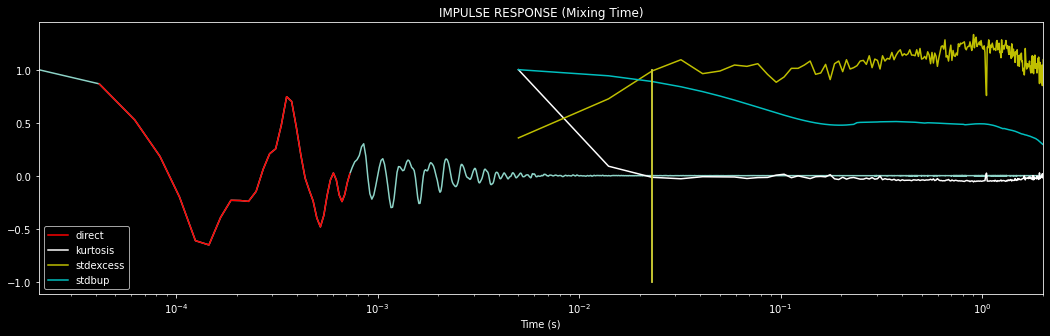

In [14]:
pstat = irstat_plot(ir1, window=0.01, overlap=0.001, logscale=True, fs=fs)

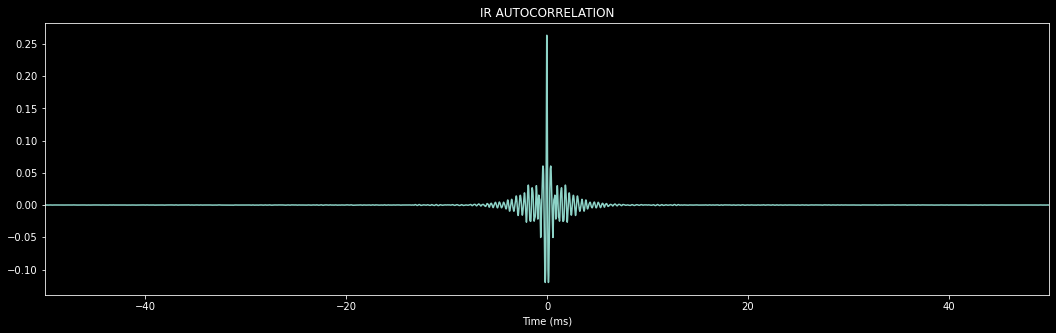

In [15]:
ac = acorr_plot(ir1,trange=0.05,fs=fs)

# Parametros acusticos

Calculo de los parametros acusticos usando paracoustic, el primer parametro es la RI (el array o el nombre de archivo), se puede especificarl el metodo para calcular el tiempo de reverberacion (rt30, rt20, rt15) y el banco de filtros a utilizar (el formato de nombre para el banco de filtros es fbank + frecuencia de sampleo + _ + numero de octavas + _ + numero de bandas por octavas. Por defecto el banco arranca en la octava de 62.5 para modificarlo se puede usar la funcion make_filterbank de process.

**paracoustic** devuelve un diccionario con todos los parametros por bandas, y dos columnas adicionales para ponderacion A y Flat. 

**pars_print** imprime todos los parametros (tambien se le puede pasar una lista de keys).

**pars_plot** hace graficos de los parametros que se le pasan como key.

Los parametros que se calculan son
- 'snr' relacion señal ruido en dB
- 'rt20' (o 'rt30' o 'rt15) tiempo de reverberacion en segundos
- 'edt' decaimiento temprano en segundos
- 'c50' y 'c80' claridad en dB con dos criterios
- 'ts' centro temporal en segundos
- 'dr' relacion directo reverberante en dB

Pero paracoustic tambien devuelve:
- 'rvalue' coeficiente de regresion del ajuste del decaimiento (puede incorporarse a parsprint)
- 'schr' integral de Schroeder para graficar el decaimiento
- 'lfit' 'tfit' intersecciones con tiempo y nivel donde realiza el ajuste de decaimiento

La funcion **parsdecay_plot** muestra los decaimientos por bandas en un multiplot.

En todos los casos muestra los datos de un solo canal (por defecto el canal 0 pero se puede especificar con el parametro chan)

In [13]:
#from irma.process import make_filterbank
make_filterbank(fmin=62.5,noct=9,bwoct=1,fs=fs,bankname='fbank48k_9_1',show=True)

Banco de filtros generado: 9 octavas,1 bandas/octava,desde 62.5 Hz,Almacenada en archivo fbank48k_9_1


In [14]:
pars = paracoustic(ir1, method='rt20',bankname='fbank48k_9_1')

Using sample rate from filter bank:48000
(275456, 1)
144000
144000
144000
144000
144000
144000
144000
144000
144000
144000
144000
144000
144000
144000
144000
144000
144000
144000
144000
144000
144000
144000


In [15]:
pars_print(pars,chan=1)

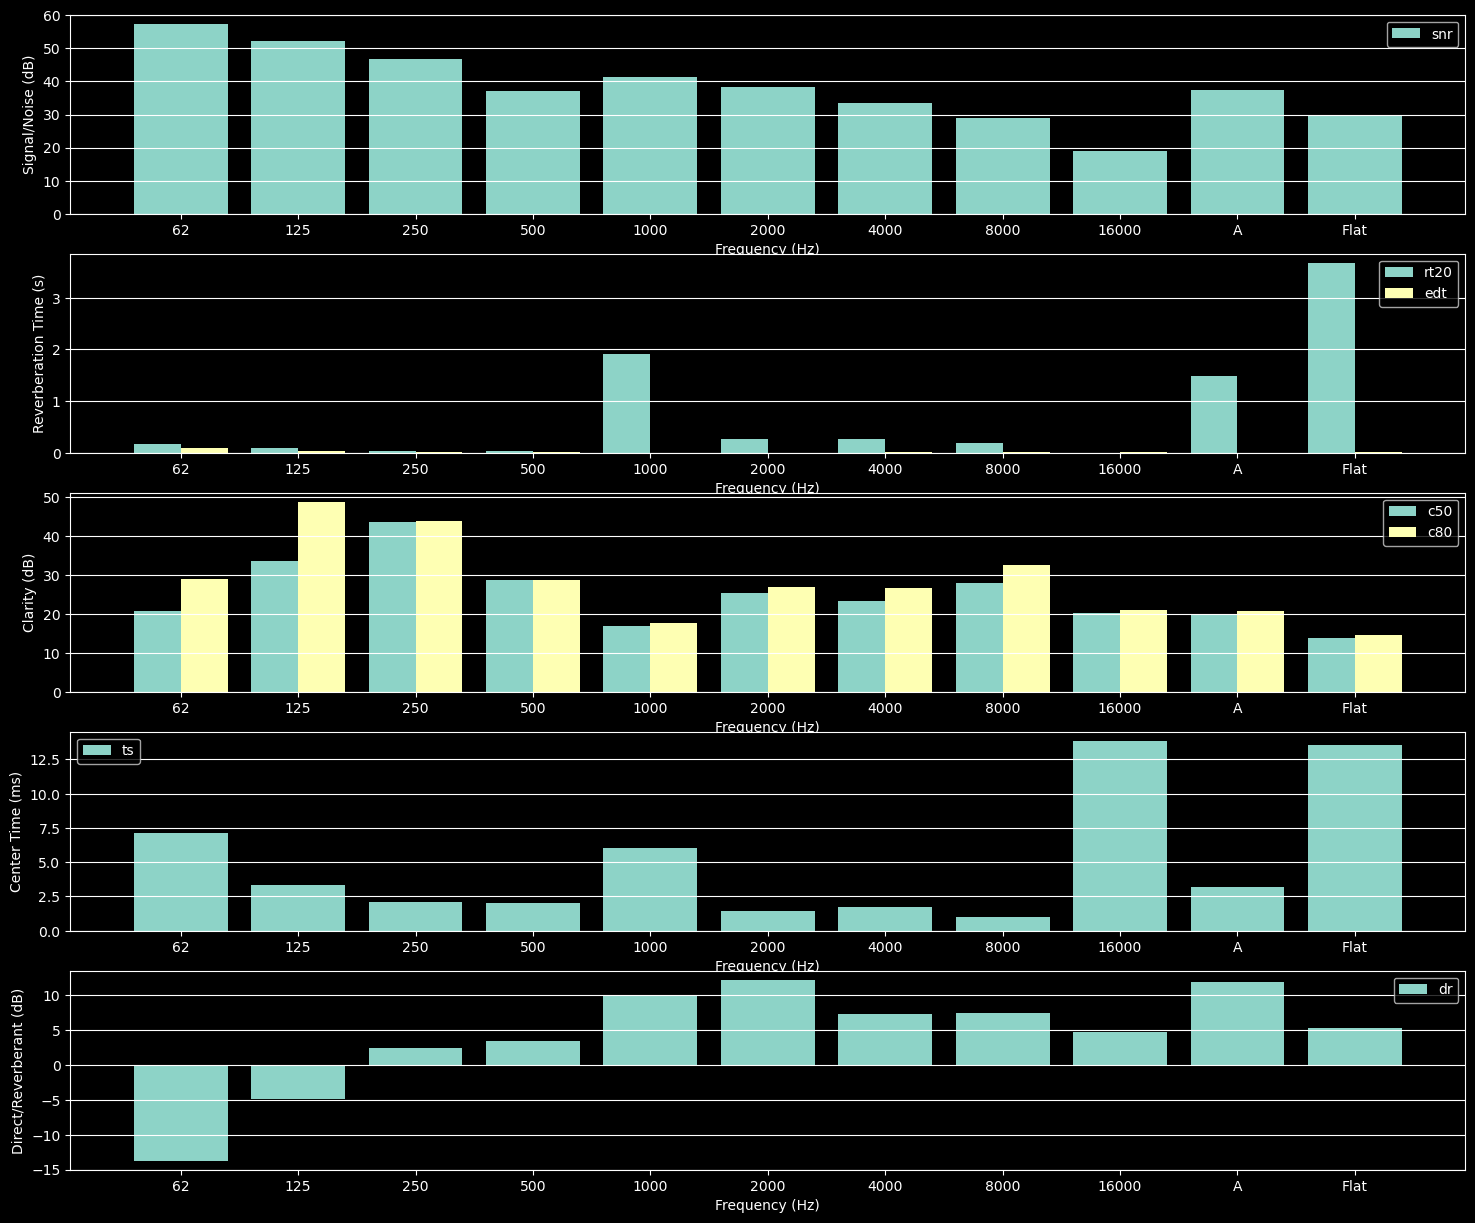

In [17]:
pars_plot(pars,['SNR','RT20','C80','TS','DRR'],chan=1);

([<AxesSubplot:xlabel='Frequency (Hz)', ylabel='Reverberation Time (s)'>],
 <Figure size 1800x300 with 1 Axes>)

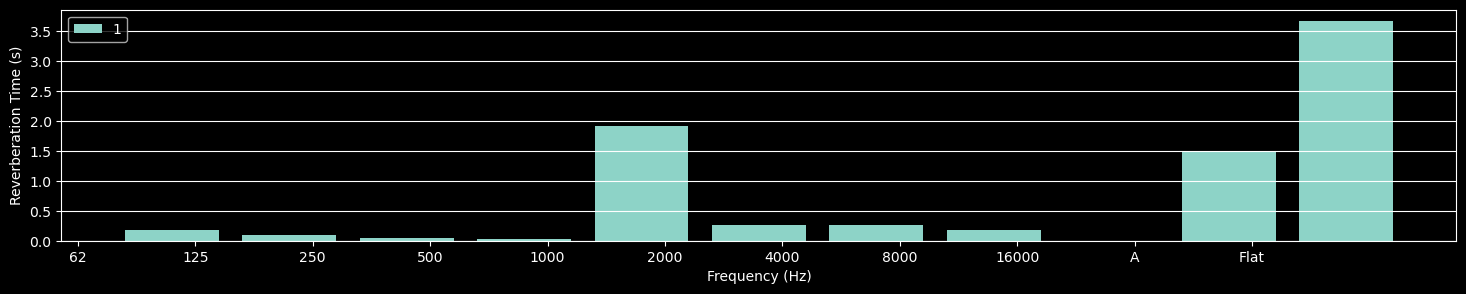

In [18]:
pars_plot_compared(pars, 'rt20')

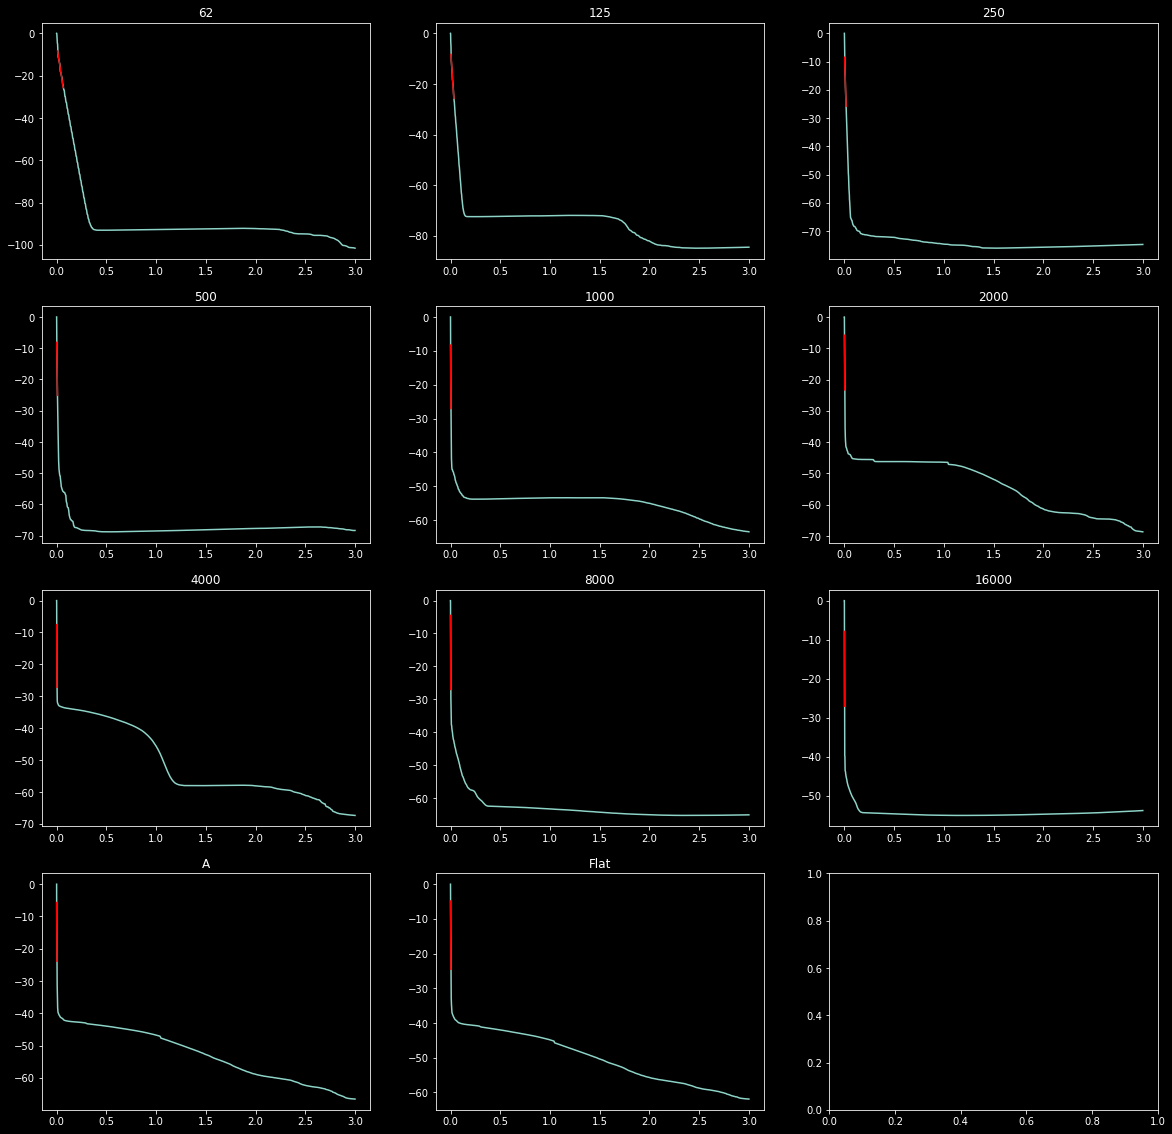

In [20]:
parsdecay_plot(pars,fs=fs)

# Funcion Transferencia

La funcion **spectrum_plot** grafica y devuelve el espectro (power spectral density) y la fft como amplitud y fase de una señal arbitraria (multicanal)

Si pasamos la respuesta impulso como señal recibimos la funcion de transferencia. El primer parametro puede ser un array o un nombre de archivo. Si es array hay que especificar la frecuencia de sampleo. logscale se refiere a la escala de frecuencias (la magnitud esta en dB). fmax es la frecuencia maxima que muestra en el grafico pero calcula todo hasta Nyquist. Devuelve un diccionario con keys 'f' 's' 'amplitude' 'phase' correspondientes a la lista de frecuencias, y arrays 2D (un canal por fila) con el espectro de potencias, la amplitud y la fase de la fft respectivamente.
bajo

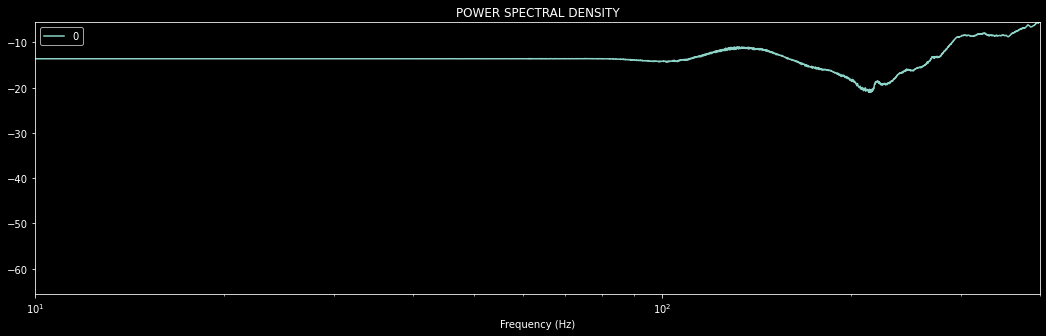

In [21]:
sp = spectrum_plot(ir1, logscale=True, fmax=400, fs=fs)

# Espectrograma

Como en el caso anterior, **spectrogram_plot** grafica y devuelve el espectrograma (ahora de un solo canal que se puede especificar con el parametro chan). 
recibe como parametros ademas de la señal en primero lugar, el tamaño de ña ventana en samples 'window', el overlap de las ventanas en samples 'overlap' la frecuencia de sampleo y el rango en dB 'lrange'. 'normalize' = True normaliza la salida en amplitud.
Atencion, por ahora necesita el array (no el nombre de archivo)

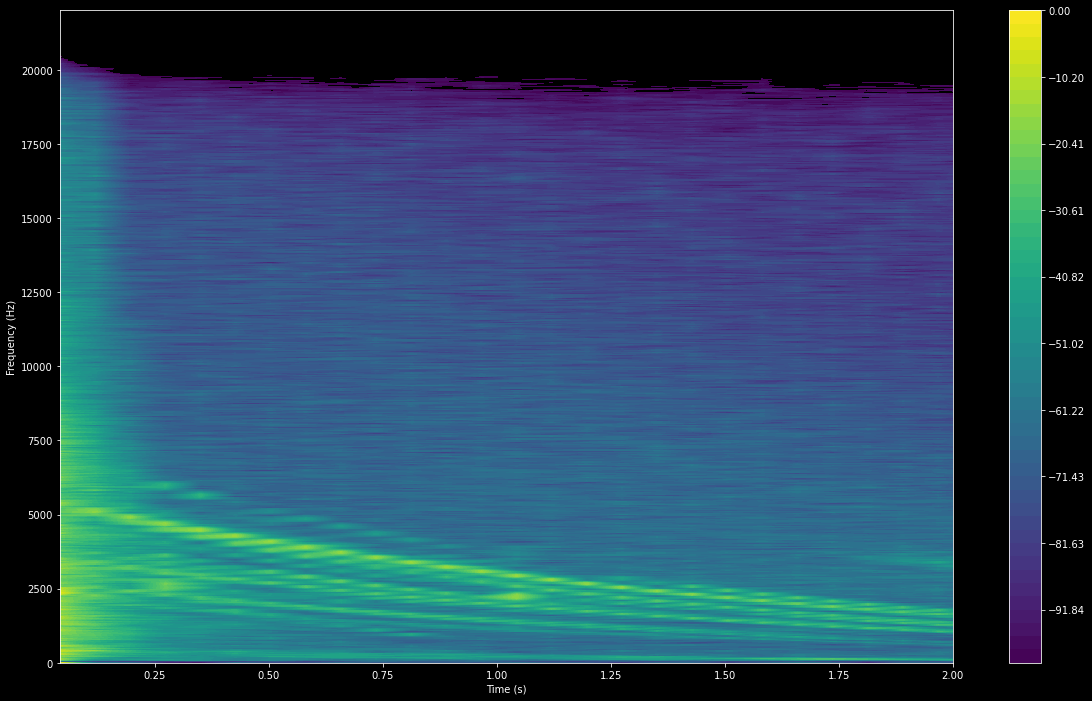

In [22]:
spec = spectrogram_plot(ir1,4096,400,chan=0,normalized=True,fs=fs,lrange=100,fmax=22000)

# ANEXO. 

Reproducir y grabar un archivo de audio, en otra sesion para diferenciar

In [5]:
tipo = "rec"
inchan = [1,2]
outchan = [1]
parlantes = ["L","R","centro","orq"]
mics = ["pub1","pub2"]
s2 = RecordingSession("Session2",parlantes,mics,inchan=inchan,outchan=outchan,rtype=tipo,sweepfile="sweep_x1_48k_10s_30_22k")

In [15]:
#filename = "audios/Pasaje compuesto de estímulos varios"
parlante = 8
direction = 5
mic = 2
take = 2
#s2.playrec_file(filename,parlante,mic,take=take,channel=0,comment=' prueba')

In [17]:
#s2.save_metadata("Session2_full")

In [2]:
s = RecordingSession.load_metadata("../../lula.yaml")

In [3]:
s.list_recordings()

0:lula_S1_M1_D6_1ch_
1:lula_S1_M1_D2_1ch
2:lula_S1_M1_D1_1ch
3:lula_S1_M1_D4_1ch


In [4]:
# carga una ir por numero de grabacion arrancando de 0
s.recording_path = "../../"

In [5]:
ir3 = s.load_ir(3)

(0.0, 1.0)

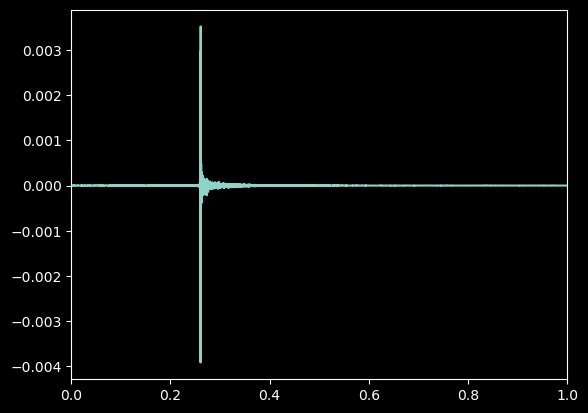

In [6]:
plt.plot(np.arange(len(ir3))/48000,ir3)
plt.xlim(0,1.0)

C:\Users\Camilo\acousticfield\src\acousticfield\room.py:286: RuntimeWarning: divide by zero encountered in log10
  stdb = signal.savgol_filter(10*np.log10(pars['std'][:,0]),51,3,axis=0)
C:\Users\Camilo\acousticfield\src\acousticfield\display.py:148: RuntimeWarning: invalid value encountered in true_divide
  axs[n].plot(pstat['tframe'],pstat['stdbup'][:,n]/stdbupmax,'c',label='stdbup')


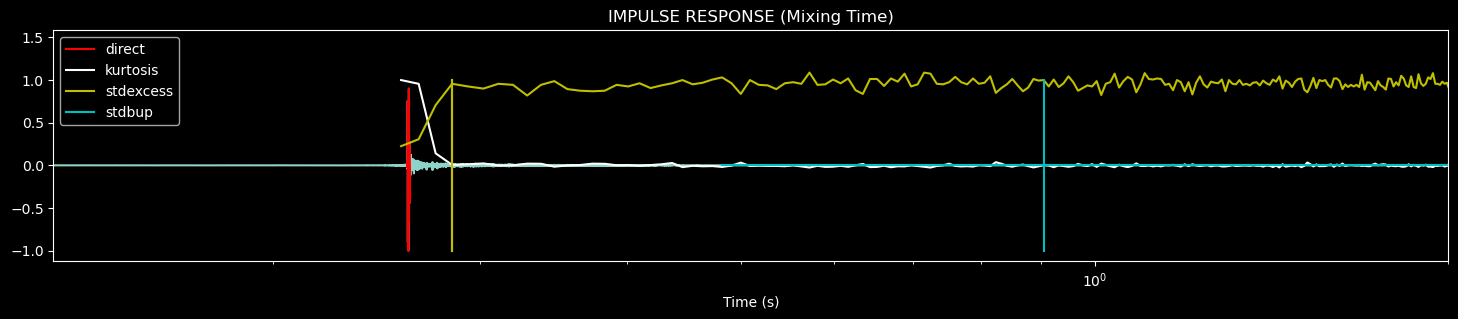

In [8]:

fs = 48000
pstat = irstat_plot(ir3, window=0.01, overlap=0.001, logscale=True, fs=fs)

In [28]:
from scipy import signal 
from scipy.stats import linregress, kurtosis

def irstats2(ir, window=0.01, overlap=0.005, fs=48000):
    if type(ir) is str:
        fs, data = wavfile.read(ir + '.wav')
    elif type(ir) is np.ndarray:
        data = ir
    else:
        raise TypeError('Input must be ndarray or filename')    
    if data.ndim == 1:
        data = data[:,np.newaxis] # el array debe ser 2D
    kurt_confidence = 0.5
    excess_confidence = 0.9
    stdbup_confidence = 1.0
    ndir = find_dir(data, fs=fs)
    nsamples, nchan = np.shape(data)
    listofkeys = ['chan','tframe','std','kurtosis','stdexcess','stdbup']
    pars = dict.fromkeys(listofkeys,0 )
    pars['nchan'] = nchan
    pars['nchan'] = nchan
    nwindow = int(window*fs)
    noverlap = int(overlap*fs)
    nframes = int(np.floor((nsamples-noverlap)/(nwindow-noverlap)))
    frames = [[(nwindow-noverlap)*n,(nwindow-noverlap)*n+nwindow] for n in range(nframes)]
    print(frames)
    pars['tframe'] = np.zeros((nframes,1))
    pars['std'] = np.zeros((nframes,nchan))
    pars['kurtosis'] = np.zeros((nframes,nchan))
    pars['stdexcess'] = np.zeros((nframes,nchan))
    pars['stdbup'] = np.zeros((nframes,nchan))
    pars['mixing'] = np.zeros((2,nchan))
    pars['tnoise'] = np.zeros((1,nchan))
    for m in range(nframes):
        fr = data[frames[m][0]:frames[m][1],:]
        pars['tframe'][m] = np.mean(frames[m])/fs
        av = np.mean(fr,axis=0)
        isdir = np.full((nchan,),np.nan)
        isdir[frames[m][1] > ndir[0,:]] = 1
        temp = np.std(fr,axis=0) * isdir
        if np.any(np.isnan(temp)):
            pars['std'][m] = np.zeros((1,nchan))   
        else:
            pars['std'][m] = temp
        pars['kurtosis'][m] = kurtosis(fr,axis=0) * isdir
        pars['stdexcess'][m] = np.mean(np.abs(fr-av)>pars['std'][m],axis=0)*3.0*isdir
    nmix = np.argmax(pars['kurtosis']<kurt_confidence,axis=0)    
    pars['mixing'][0,:] = pars['tframe'][nmix][:,0]
    nmix = np.argmax(pars['stdexcess']>excess_confidence,axis=0)
    pars['mixing'][1,:] = pars['tframe'][nmix][:,0]
    for n in range(nchan):
        stdb = signal.savgol_filter(10*np.log10(pars['std'][:,0]),51,3,axis=0)
        pars['stdbup'][:,n] = stdb-np.nanmin(stdb)
        #nwdir = int(ndir[0,n]/nwindow)
        #pars['stdbup'][:nwdir,] = 0
    nnoise = np.argmax(pars['stdbup']<stdbup_confidence,axis=0)    
    pars['tnoise'][0,:] = pars['tframe'][nnoise][:,0]
    return pars    


In [36]:
irs = irstats(ir3, window=0.01, overlap=0.001)

LinAlgError: SVD did not converge in Linear Least Squares

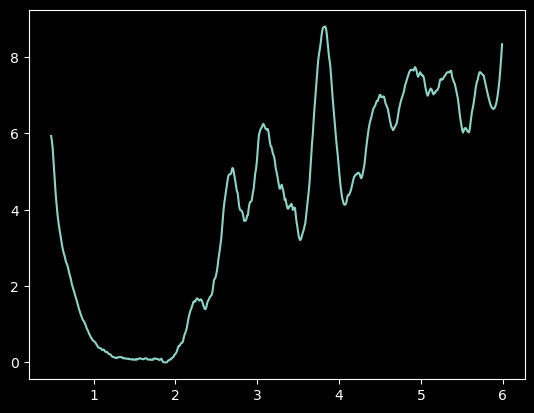

In [30]:
plt.plot(irs['tframe'],irs['stdbup'][:,0])

In [31]:
irs['tnoise']

array([[0.905]])